# Применение библиотеки Tensor Flow Probability для прогнозирования структурных временных рядов и поиска аномалий

Для анализа использутеся модуль tfp.sts. Отличается тем, что на каждом шаге построения прогноза изменение прогнозируемого значения по сравнению с предыдущем является случайной величиной, подчиненной по умолчанию нормальному закону распределения. Это позволяет создавать не один прогноз, а набор прогнозов, основной из которых тот, где измнения прогнозируемых значений представляют собой выборочные средние.

[Ссылка на документацию](https://www.tensorflow.org/probability/api_docs/python/tfp/sts)

#1. Импортируем необходимые модули

In [1]:
import seaborn as sns
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt

import collections


In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


# 2.Импортируем данные

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project workshop/2 sprint/Datasets/1019168_190.csv', delimiter = ',')

df

time  ta_id      blockID  blockDur  t_trp  b_trp  \
0      2018/01/01 05  190.0   60273318.0     240.0  1.038  0.944   
1      2018/01/01 05  190.0   60273319.0     240.0  0.836  0.752   
2      2018/01/01 06  190.0   60273320.0     240.0  0.791  0.671   
3      2018/01/01 06  190.0   60273297.0     240.0  0.455  0.371   
4      2018/01/01 07  190.0   60273299.0     180.0  0.527  0.454   
...              ...    ...          ...       ...    ...    ...   
92877  2022/06/06 01  190.0  269922854.0     240.0  0.596  0.356   
92878  2022/06/06 01  190.0  269922863.0     240.0  0.689  0.392   
92879  2022/06/06 01  190.0  269922864.0     240.0  0.610  0.338   
92880  2022/06/06 02  190.0  269922865.0     180.0  0.541  0.306   
92881  2022/06/06 02  190.0  269922866.0     180.0  0.457  0.259   

                 real_time  
0      2018-01-01 05:19:30  
1      2018-01-01 05:43:00  
2      2018-01-01 06:06:30  
3      2018-01-01 06:49:24  
4      2018-01-01 07:07:48  
...                    ...  
92877  2022-06-06 01:00:15  
92878  2022-06-06 01:27:20  
92879  2022-06-06 01:43:40  
92880  2022-06-06 02:14:20  
92881  2022-06-06 02:32:40  

[92882 rows x 7 columns]

In [4]:
df['date'] = pd.to_datetime(pd.to_datetime(df['real_time']).dt.date)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92882 entries, 0 to 92881
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       92882 non-null  object        
 1   ta_id      92882 non-null  float64       
 2   blockID    92882 non-null  float64       
 3   blockDur   92882 non-null  float64       
 4   t_trp      92882 non-null  float64       
 5   b_trp      92882 non-null  float64       
 6   real_time  92882 non-null  object        
 7   date       92882 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 5.7+ MB


Данные представляют собой не эквидистантый временной ряд, отражающий рейтинги телесмотрения. Целевой величиной для прогнозирования и поиска аномалий является t_trp.

Хотя модуль имеет возможность построения модели с пропущенными данными, а также способен восстанавливать отсутствующие части последовательности (см. документацию ), все равно ресемплируем датасет, чтобы сделать его эквидистантным и восстановим пропуски в данных.

#3.Ресемплируем датасет

In [5]:
df_use = df[df['real_time'].between('2021-05-31 00:00:00', '2022-06-03 00:00:00', inclusive='both')].drop(columns='time')

# df_use #ограничим используемоые данные в датасете + некоторое время вперед и назад для корректной интерполяции данных на границах

In [6]:
gen = pd.date_range('2021-05-31 00:00:00', '2022-06-03 00:00:00', freq='H') #генерируем последовательность дат

In [7]:
time_new = pd.concat([df_use['real_time'], pd.Series(gen)], ignore_index=True, sort=True)

# time_new #колонка времени, скомбинированная из колонки времени начального датасета и сгенерированных дат

In [8]:
df_full = df_use.merge(pd.Series(time_new, name='time'), left_on='real_time', right_on='time', how='right') \
                .drop(columns='real_time').astype({'time':'datetime64'}).sort_values(by='time').reset_index(drop=True)

df_full['int'] = df_full['t_trp'].interpolate(metod='time')

df_full = df_full[df_full['time'].between('2021-05-31 23:00:00', '2022-05-31 23:00:00', inclusive='both')]

# df_full #датасет с интерполяцией данных по t_trp на строки с временем вида 00:00:00

In [9]:
df_res = df_full.loc[pd.isna(df_full['date']) == True].drop(columns={'ta_id', 'blockID', 'blockDur', 't_trp', 'b_trp', 'date'}) \
                                                      .rename(columns={'int':'t_trp'}).reset_index(drop=True)

df_res = df_res[df_res['time'].between('2021-11-30 00:00:00', '2022-05-31 23:00:00', inclusive='both')] 

df_res #ресемплированный датасет из t_trp и времени. Используется для построения графика и для обучения.

time    t_trp
4369 2021-11-30 00:00:00  0.95050
4370 2021-11-30 01:00:00  0.50000
4371 2021-11-30 02:00:00  0.33050
4372 2021-11-30 03:00:00  0.26725
4373 2021-11-30 04:00:00  0.27550
...                  ...      ...
8756 2022-05-31 19:00:00  4.90900
8757 2022-05-31 20:00:00  5.70950
8758 2022-05-31 21:00:00  7.53950
8759 2022-05-31 22:00:00  7.67500
8760 2022-05-31 23:00:00  5.38150

[4392 rows x 2 columns]

#4.Пример данных

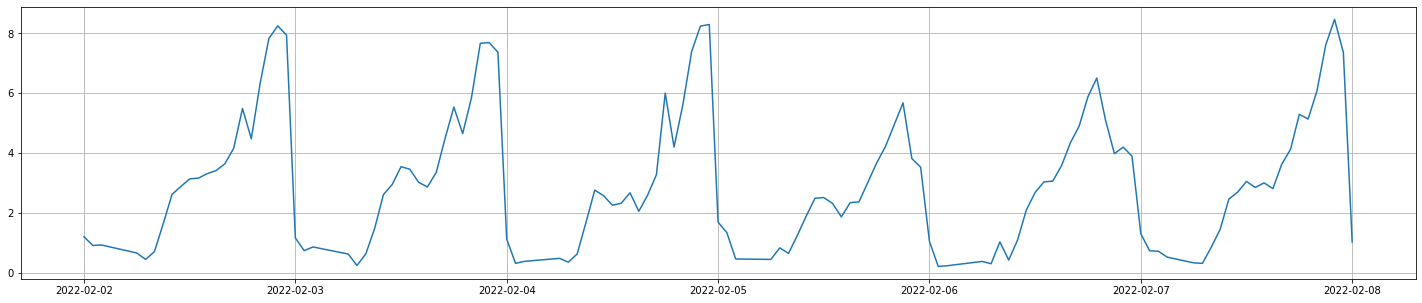

In [10]:
start_date = '2022-02-02 00:00:00'
end_date = '2022-02-08 00:00:00'
observation_dates = df_res['time'].between(start_date, end_date, inclusive='both')

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(df_res[observation_dates].time, df_res[observation_dates].t_trp)
plt.grid(True, which='both')

plt.show()

#5.Подготовка параметров для прогноза

In [11]:
num_train_starts = 0 #начало тренировочных данных относительно используемого датасета
num_forecast_steps = 31*24*2 #общее колчиество отметок времени в прогнозе
num_forecast_steps_vs_real = 31*24 #колчиество отметок времени в прогнозе для сравнения с реальностью

forecast_start = df_res['time'].iloc[-num_forecast_steps_vs_real].to_numpy() #дата и время начала прогноза

In [12]:
train_dt = df_res['t_trp'].iloc[num_train_starts:-num_forecast_steps].to_numpy() #тренировочные данные

#6.Построение и обучение модели

На данном этапе необходимо разложить временной ряд из данных на тренд и сезонность, если они есть. Также можно использовать авторегрессию и линейную регрессию, есть есть возможность и необходимость.

Наш временной ряд разложим на три сезонности (исходя из обзора данных и логики).Эти сезоны имеют устойчивые периоды и постоянно повторяются:

1. Часы в сутках - утром низкие рейтинги, чем ближе к ночи, тем выше;
2. День в недели - в выходные больше, чем в будние дни;
3. Месяцы в году - предполагается, что летом меньше, зимой больше.

In [13]:
def build_model(observed_time_series):
  hour_of_day = sts.Seasonal(
      num_seasons = 24, num_steps_per_season=1,
      observed_time_series=observed_time_series,
      name='hour_of_day')
  day_of_week = sts.Seasonal(
      num_seasons = 7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week')
  month_of_year = sts.Seasonal(
      num_seasons = 12, num_steps_per_season=24*7*4,
      observed_time_series=observed_time_series,
      name='month_of_year')
  
  model = sts.Sum([hour_of_day, day_of_week, month_of_year], observed_time_series=observed_time_series)
  return model

In [14]:
t_trp_model = build_model(train_dt)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=t_trp_model)

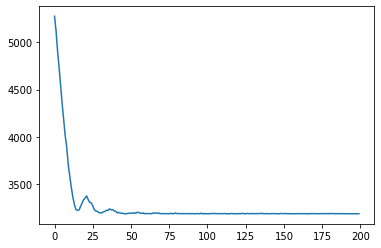

In [15]:
num_variational_steps = 200 #количество шагов при обучении модели
num_variational_steps = int(num_variational_steps)

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=t_trp_model.joint_distribution(
            observed_time_series=train_dt).log_prob,
        surrogate_posterior=variational_posteriors, 
        optimizer=tf.optimizers.Adam(learning_rate=0.1), 
        num_steps=num_variational_steps,
        jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

In [16]:
samples = variational_posteriors.sample(50)

In [17]:
print("Inferred parameters:")
for param in t_trp_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(samples[param.name], axis=0),
                              np.std(samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.6117820754100525 +- 0.009713055106001102
hour_of_day/_drift_scale: 0.13051886119424322 +- 0.012971826193947223
day_of_week/_drift_scale: 0.4101812066486525 +- 0.040210231372243284
month_of_year/_drift_scale: 0.37958492567225105 +- 0.8895139511760343


In [20]:
forecast = tfp.sts.forecast(
    t_trp_model,
    observed_time_series=train_dt,
    parameter_samples=samples,
    num_steps_forecast=num_forecast_steps)

num_samples = 10

forecast_mean, forecast_scale, forecast_samples = (
    forecast.mean().numpy()[..., 0],
    forecast.stddev().numpy()[..., 0],
    forecast.sample(num_samples).numpy()[..., 0]
    )

#7.Визуализируем прогноз

In [ ]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(300, 15))
  ax = fig.add_subplot(1, 1, 1)

  plt.grid(True, which='both')

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_forecast_steps_vs_real


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+pd.to_timedelta(num_steps_forecast, unit='h'),
      np.timedelta64(1, "h"),
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [ ]:
loc = mdates.HourLocator(interval=24)
fmt = mdates.DateFormatter('%Y-%m-%d')

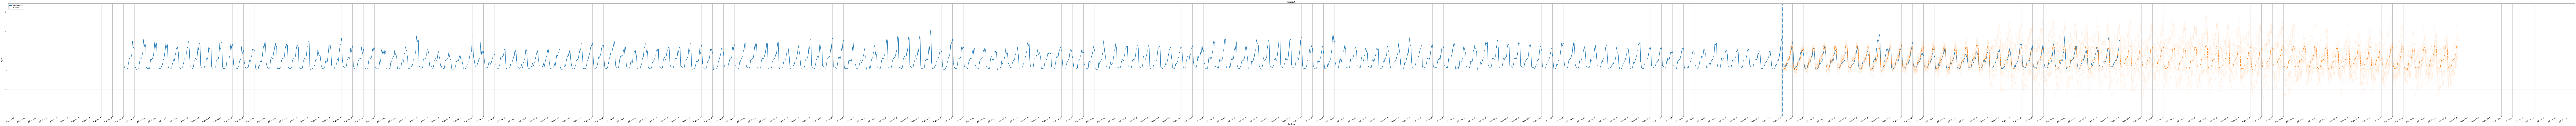

In [21]:
fig, ax = plot_forecast(
    df_res.time.to_numpy(), df_res.t_trp.to_numpy(),
    forecast_mean, forecast_scale, forecast_samples, 
    x_locator=loc, x_formatter=fmt, 
    title="Forecast")
ax.axvline(forecast_start, linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("t_trp")
ax.set_xlabel("Day-Hour")
fig.autofmt_xdate()

Также декомпозируем прогноз на сезоны:

In [22]:
component_dists = sts.decompose_by_component(
    t_trp_model,
    observed_time_series=df_res.t_trp.to_numpy(),
    parameter_samples=samples)

In [23]:
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

In [24]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(48, 10 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

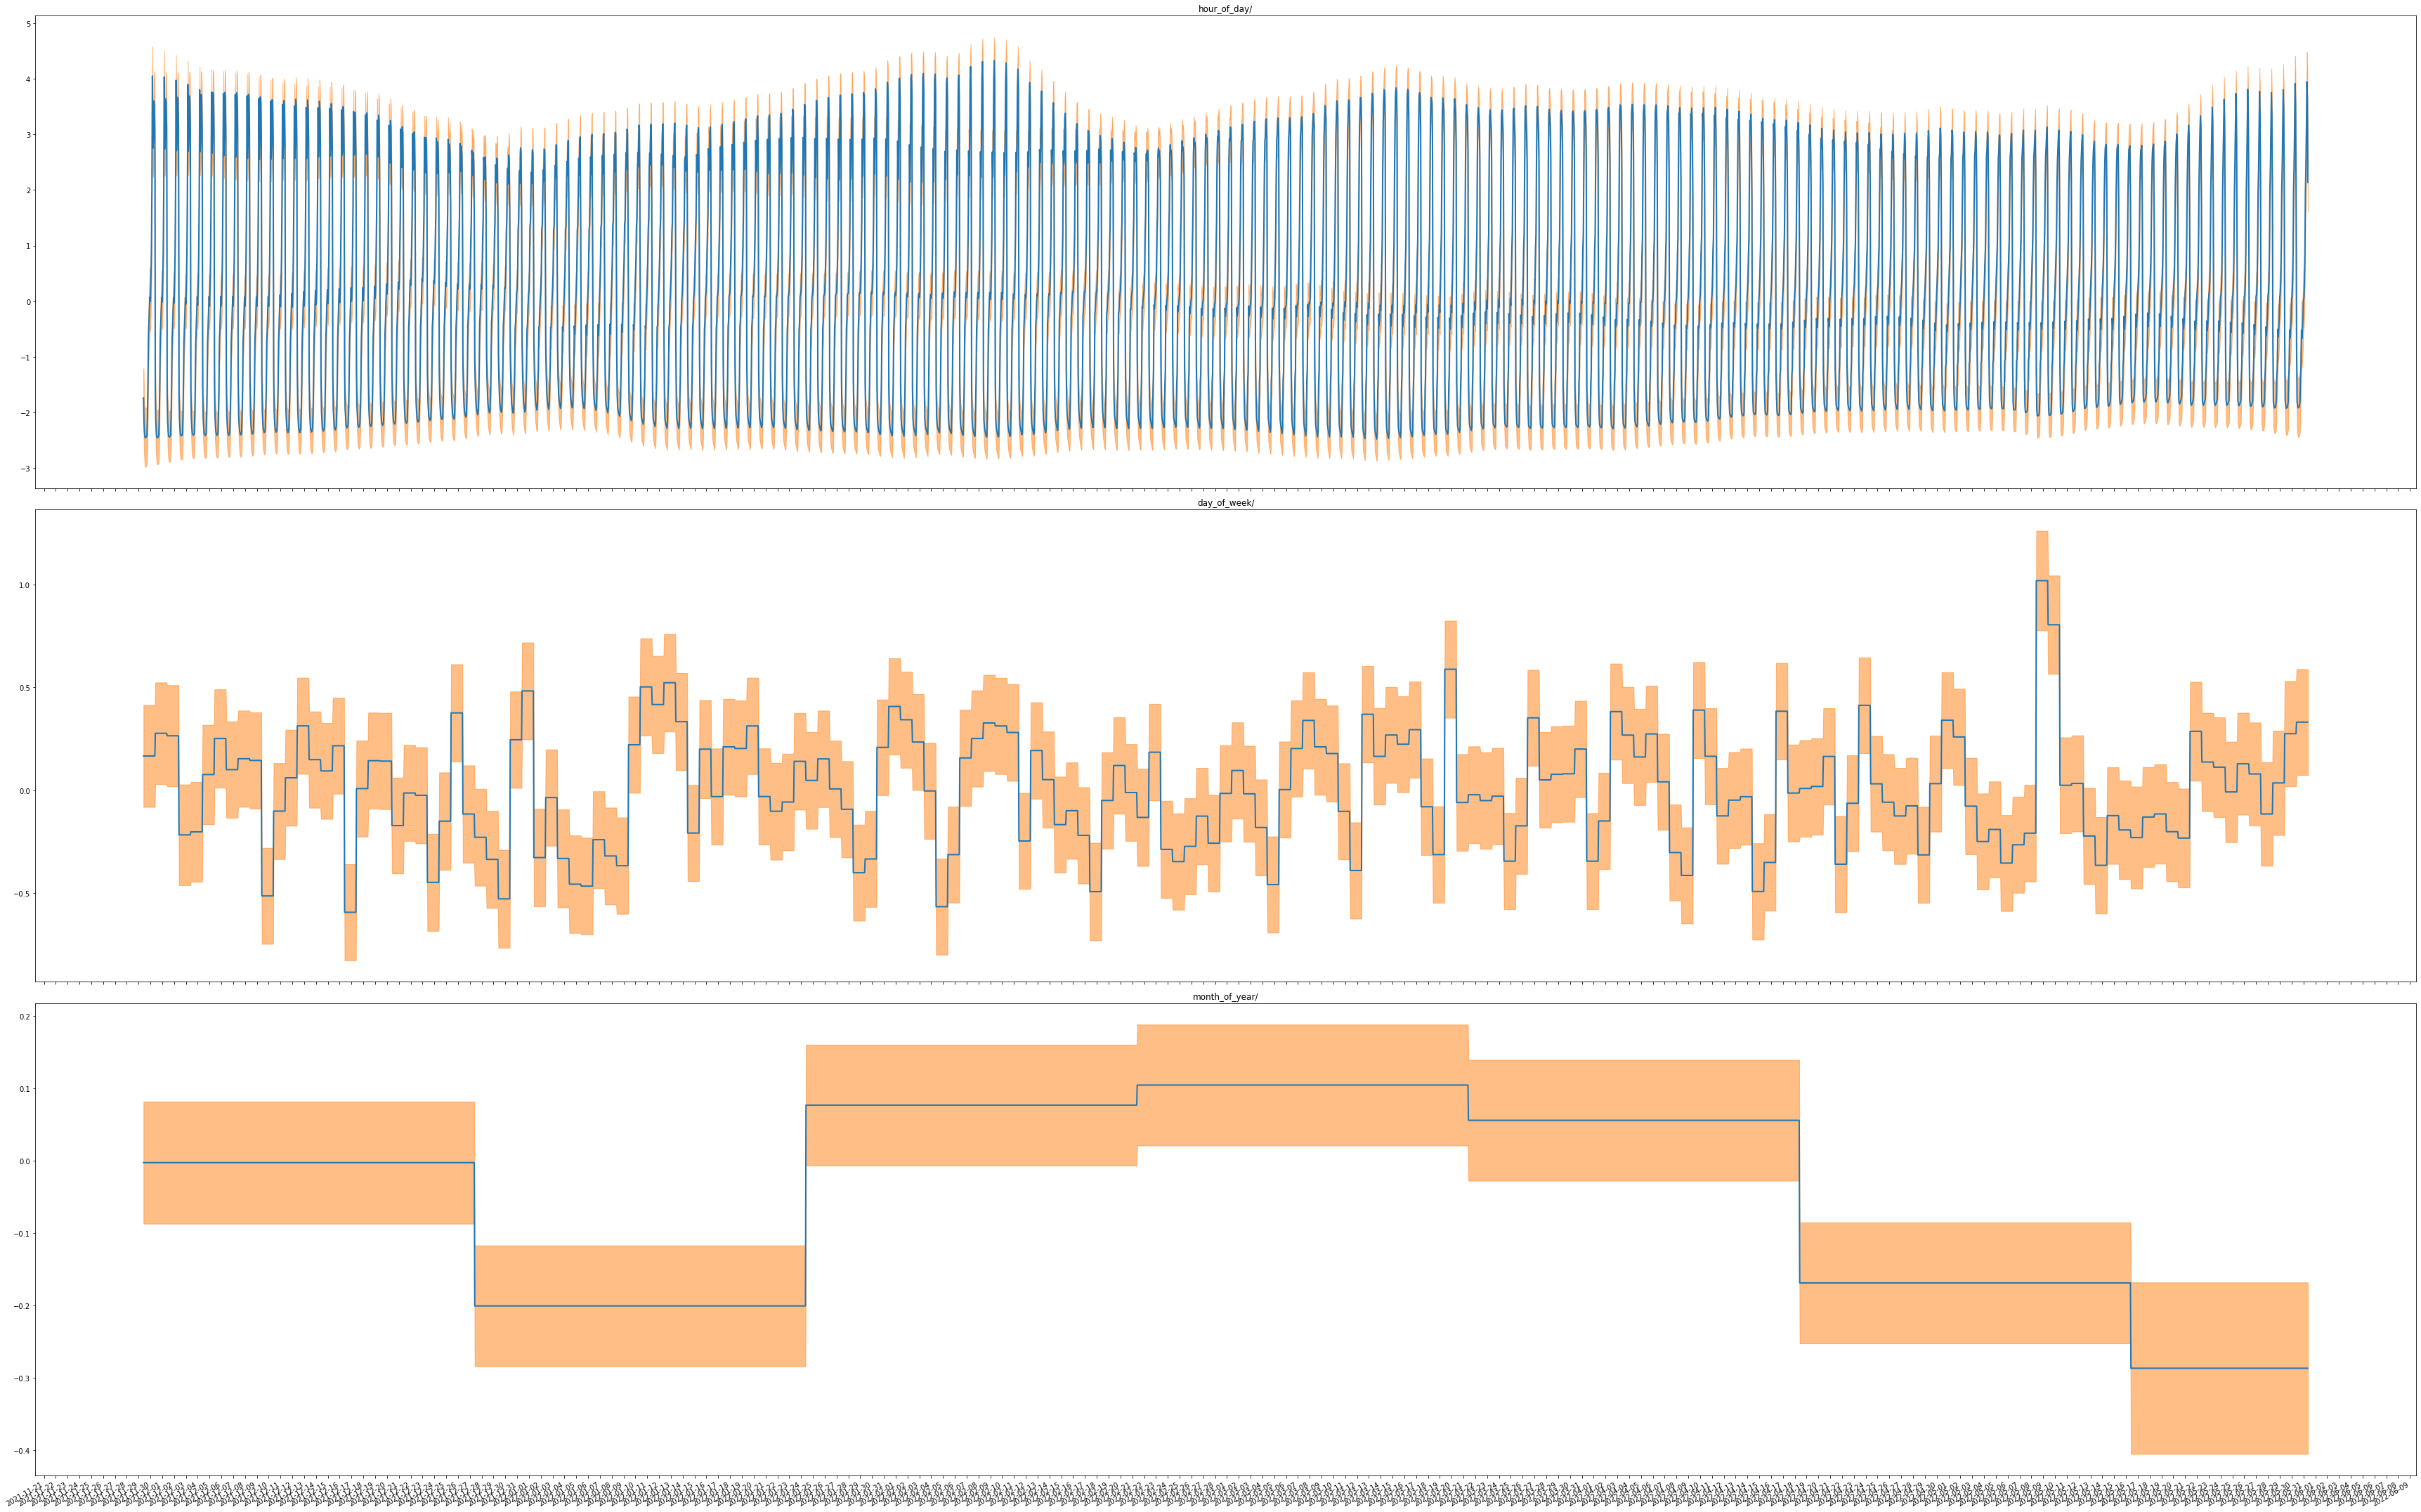

In [25]:
decomposition = plot_components(df_res.time, component_means_, component_stddevs_, x_locator=loc, x_formatter=fmt)

#8.Метрики

In [33]:
ground_truth = train_dt[-len(forecast_mean):]
errors_prediction=ground_truth-forecast_mean

mse = sum((ground_truth - forecast_mean)**2)/len(ground_truth)
rmse = (sum(abs(ground_truth - forecast_mean))/len(ground_truth))**1/2
r2 = 1 - sum((ground_truth - forecast_mean)**2)/sum((ground_truth - np.mean(forecast_mean))**2)
print('MSE = {}, RMSE = {}, R^2 = {}'.format(round(mse, 3), round(rmse, 3), round(r2, 3)))

mae = sum(abs(ground_truth - forecast_mean))/len(ground_truth)
print('MAE = {}'.format(round(mae, 3)))

mape = sum(abs(ground_truth - forecast_mean)/abs(ground_truth))/len(ground_truth)
wape = sum(abs(ground_truth - forecast_mean))/sum(abs(ground_truth))
print('MAPE = {}, WAPE = {}'.format(round(mape, 3), round(wape, 3)))

MSE = 0.581, RMSE = 0.248, R^2 = 0.877
MAE = 0.497
MAPE = 0.272, WAPE = 0.179


#9.Прогноз на один шаг и поиск аномалий

In [26]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(300, 15))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

In [28]:
t_trp_one_step_dist = sts.one_step_predictive(
    t_trp_model,
    observed_time_series=df_res.t_trp.to_numpy(),
    parameter_samples=samples)

t_trp_one_step_mean, t_trp_one_step_scale = (
    t_trp_one_step_dist.mean().numpy(), t_trp_one_step_dist.stddev().numpy())

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


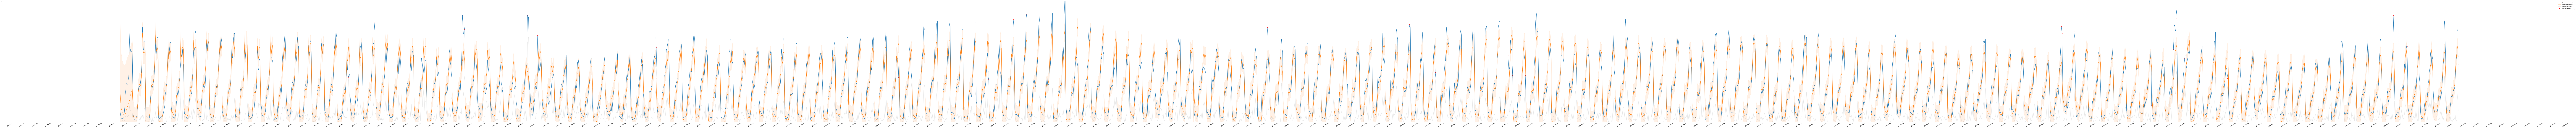

In [29]:
fig, ax = plot_one_step_predictive(
    df_res.time.to_numpy(), df_res.t_trp.to_numpy(),
    t_trp_one_step_mean, t_trp_one_step_scale,
    x_locator=loc, x_formatter=fmt)
ax.set_ylim(0, 10)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((df_res.t_trp.to_numpy() - t_trp_one_step_mean) /
                 t_trp_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(df_res.time.to_numpy()[anomalies],
           df_res.t_trp.to_numpy()[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(df_res.time.to_numpy(), zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()

Оценить резульаты поиска аномалий можно только визуально, поскольку датасет не имеет разметки аномалий.